In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(101)

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
digits = [3, 5, 8, 9]
n_px = 8

train_size = 10000
test_size = 2000

batch_size = 32
epochs = 20

In [94]:
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    # Load raw data (uint8 [0-255])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)

    # Helper: filter, sample, normalize, resize
    def prepare(data, targets, digits, size, n_px):
        # Filter by class
        mask = torch.zeros_like(targets, dtype=torch.bool)
        for d in digits:
            mask |= (targets == d)
        data_f = data[mask]
        targ_f = targets[mask]

        # Sample 'size' examples
        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float() / 255.0  # [size,1,28,28]
        labs = targ_f[idx]

        # Resize to n_px x n_px
        imgs_resized = F.interpolate(imgs, size=(n_px, n_px), mode='bilinear', align_corners=False)
        # Map labels to 0..len(digits)-1
        labs_mapped = torch.tensor([digits.index(int(l)) for l in labs])
        return imgs_resized, labs_mapped

    x_train, y_train = prepare(mnist_train.data, mnist_train.targets, digits, train_size, n_px)
    x_test, y_test   = prepare(mnist_test.data, mnist_test.targets,   digits, test_size,  n_px)
    return (x_train, y_train), (x_test, y_test)

In [95]:
# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=train_size, test_size=test_size)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

In [96]:
X_train = np.array(np.reshape(x_train, (len(x_train), n_px, n_px)))
X_test = np.array(np.reshape(x_test, (len(x_test), n_px, n_px)))
Y_train = np.array(y_train)
Y_test = np.array(y_test)

print('X')
print(f'Shape : {X_train.shape}')
print(f'dType : {X_train.dtype}')
print(f'pyType: {type(X_train)}')

print('Y')
print(f'Shape : {Y_train.shape}')
print(f'dType : {Y_train.dtype}')
print(f'pyType: {type(Y_train)}')

X
Shape : (10000, 8, 8)
dType : float32
pyType: <class 'pennylane.numpy.tensor.tensor'>
Y
Shape : (10000,)
dType : int64
pyType: <class 'pennylane.numpy.tensor.tensor'>


In [100]:
#### Hyperparameters ####
input_dim = n_px * n_px # 16 X 16 pixels
num_classes = len(digits)
num_layers = 8
num_qubits = 8
num_reup = 3

class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

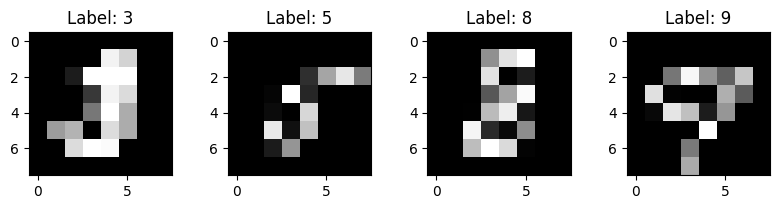

In [101]:
# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_train[y_train == i])[0].squeeze(0) for i in range(len(digits))]
y_vis = digits

# later when we train the model we include the predictions as well, so let's just add the functionality here
def visualize_data(x, y, pred=None):
    n_img = len(x)
    fig, axes = plt.subplots(1, n_img, figsize=(2*n_img, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(y[i]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(y[i], pred[i]))
    plt.tight_layout(w_pad=2)
    # plt.show()

visualize_data(x_vis, y_vis)

In [ ]:
import time
t = time.time()
#### Hyperparameters ####
learning_rate = 0.01
epochs = 100
batch_size = 40

# we use a subset of the training and validation data for this tutorial to speed up the training
n_train = 1000
n_test = 200

feats_train = torch.from_numpy(X_train[:n_train]).reshape(n_train, -1).to(device)
feats_test = torch.from_numpy(X_test[:n_test]).reshape(n_test, -1).to(device)
labels_train = torch.from_numpy(Y_train[:n_train]).to(device)
labels_test = torch.from_numpy(Y_test[:n_test]).to(device)
num_train = feats_train.shape[0]

# initialize the model, loss function and optimization algorithm (Adam optimizer)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size

# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc

# generate randomly permutated batches to speed up training
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# display accuracy and loss after each epoch (to speed up runtime, only do this for first 100 samples)
def print_acc(epoch, max_ep=epochs):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )

print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# optimize over model parameters for given number of epochs
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

elapsed = time.time() - t
print(f"\nTime elapsed: {elapsed} s.")

Starting training loop for quantum variational classifier (8 qubits, 8 layers)...
Epoch 0/100 | Approx Cost (train): 1.3845421 | Cost (val): 1.3865039 | Approx Acc train: 0.2200000 | Acc val: 0.2250000
Epoch 1/100 | Approx Cost (train): 1.3496218 | Cost (val): 1.3650697 | Approx Acc train: 0.3200000 | Acc val: 0.3200000
Epoch 2/100 | Approx Cost (train): 1.2688770 | Cost (val): 1.2862529 | Approx Acc train: 0.5000000 | Acc val: 0.4800000


In [45]:
def print_qml_classifier_summary(model):
    print("QML_classifier Summary:")
    print(f"  Input dim:    {input_dim}")
    print(f"  Output dim:   {model.output_dim}")
    print(f"  Num qubits:   {model.num_qubits}")
    print(f"  Num layers:   {model.num_layers}")
    print(f"  Num reup:     {num_reup}")
    print()

    print("Quantum Circuit Layer:")
    total_params = 0
    for name, param in model.qcircuit.named_parameters():
        print(f"  {name:<10} shape: {tuple(param.shape)} - {param.numel()} params")
        total_params += param.numel()

    print(f"\nTotal trainable parameters: {total_params}")

# Usage
model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
print_qml_classifier_summary(model)


QML_classifier Summary:
  Input dim:    256
  Output dim:   4
  Num qubits:   8
  Num layers:   32
  Num reup:     3

Quantum Circuit Layer:
  weights    shape: (32, 8, 3) - 768 params
  bias       shape: (32, 8, 3) - 768 params

Total trainable parameters: 1536
